<a href="https://colab.research.google.com/github/ozgurhaddur/braintumorsegmentation/blob/main/braintumorsegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Verilerin zip icerisinden cıkarilmasini saglamaktadir.
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/BraTS2020_TrainingData.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [3]:
#Goruntu isleme ve sinir aglari uzerine kullanilacak olan gerekli kutuphaneler
import numpy
import random as r
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import keras
import os
import numpy as np
!pip install simpleitk

#Verilerin bulundugu klasor yolu
yol = '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

print(os.listdir(yol))
print(len(os.listdir(yol)))

     |████████████████████████████████| 47.4MB 65kB/s 
['BraTS20_Training_022', 'BraTS20_Training_002', 'BraTS20_Training_001', 'BraTS20_Training_009', 'BraTS20_Training_007', 'BraTS20_Training_017', 'BraTS20_Training_019', 'survival_info.csv', 'name_mapping.csv', 'BraTS20_Training_013', 'BraTS20_Training_016', 'BraTS20_Training_020', 'BraTS20_Training_025', 'BraTS20_Training_006', 'BraTS20_Training_014', 'BraTS20_Training_012', 'BraTS20_Training_010', 'BraTS20_Training_024', 'BraTS20_Training_015', 'BraTS20_Training_004', 'BraTS20_Training_008', 'BraTS20_Training_005', 'BraTS20_Training_021', 'BraTS20_Training_018', 'BraTS20_Training_011', 'BraTS20_Training_023', 'BraTS20_Training_003']
27


In [4]:
#Dosyanin icindeki segmente edilmis goruntulerin islenebilmesi icin goruntuleri bir diziye atan fonksiyon

def seg_array(path,end,label):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        
        if label == 1:
            img[img != 0 ] = 1 # tam tümör
        if label == 2:
            img[img != 1 ] = 0 # nekroz
        if label == 3:
            img[img == 2 ] = 0 # ödemsiz tümör
            img[img != 0 ] = 1
        if label == 4:
            img[img != 4 ] = 0 # genişleyen tümör
            img[img == 4 ] = 1
         
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32) #!!!!!!!!

#Dosyanin icinde train edilecek goruntulerin islenebilmesi icin goruntuleri bir diziye atan fonksiyon

def train_array(path,end):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        img = (img-img.mean())/ img.std()
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32) #!!!!!!!!

In [5]:
#Diziye atilan Flair,T2 ve radyoloji uzmanları tarafindan segmente edilmis goruntulerin bir degiskene atanarak modele verilecek hale getirilmesi

flair=train_array(yol,'**/*flair.nii')
t2=train_array(yol,'**/*t2.nii')
seg = seg_array(yol,'**/*seg.nii',1)


In [6]:
flair.shape, seg.shape, t2.shape

((1750, 1, 240, 240), (1750, 1, 240, 240), (1750, 1, 240, 240))

In [7]:
flair.dtype, seg.dtype, t2.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

In [8]:
x_train = np.concatenate((flair,t2),axis=1)
x_train.dtype, x_train.shape

(dtype('float32'), (1750, 2, 240, 240))

In [9]:
#Egitim icin kullanilacak sinir aglari icin gerekli kutuphaneler

from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

K.set_image_data_format('channels_first')

#Egitim sonucunda modelin dogruluk(accuracy)oranini ondalik sekilde veren fonksiyon

def accuracy(y_true, y_pred):
    y_pred_f = K.flatten(K.round(y_pred))
    y_true_f = K.flatten(y_true)
    num = K.sum(y_true_f * y_pred_f)
    den = K.sum(y_true_f) + K.sum(y_pred_f) - num
    return num / den


#U-Net Modeli
    
def unet_model():
    
    inputs = Input((2, 240 , 240))
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

#Dogruluk(accuracy) degerinin yazdirilmasi icin modelin asagidaki sekilde compile edilmesi gerekmektedir.

    model.compile(optimizer = Adam(lr = 1e-4), loss = ['binary_crossentropy'], metrics = [accuracy])

    return model

model = unet_model()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [10]:
#Tahmin edilecek goruntu ve segmente edilmis goruntunun modelde fit edilmesi

model.fit(x_train,seg,validation_split=0.20,batch_size=10,epochs=30,shuffle=True,verbose=1)

Epoch 1/30
140/140 [==============================] - 144s 601ms/step - loss: 0.6173 - accuracy: 0.1703 - val_loss: 0.5827 - val_accuracy: 0.0880
Epoch 2/30
140/140 [==============================] - 84s 602ms/step - loss: 0.4003 - accuracy: 0.6734 - val_loss: 0.4740 - val_accuracy: 0.2701
Epoch 3/30
140/140 [==============================] - 80s 573ms/step - loss: 0.3113 - accuracy: 0.8009 - val_loss: 0.4373 - val_accuracy: 0.3949
Epoch 4/30
140/140 [==============================] - 80s 572ms/step - loss: 0.2686 - accuracy: 0.7876 - val_loss: 0.2073 - val_accuracy: 0.5594
Epoch 5/30
140/140 [==============================] - 80s 572ms/step - loss: 0.2094 - accuracy: 0.8389 - val_loss: 0.1590 - val_accuracy: nan
Epoch 6/30
140/140 [==============================] - 84s 602ms/step - loss: 0.1677 - accuracy: 0.8608 - val_loss: 0.1441 - val_accuracy: nan
Epoch 7/30
140/140 [==============================] - 84s 603ms/step - loss: 0.1344 - accuracy: 0.8666 - val_loss: 0.1211 - val_accurac

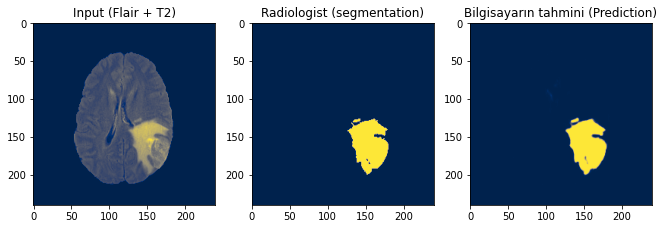

In [24]:
#Radyoloji uzmanlari tarafindan segmente edilmis goruntuler ve modelin Flair ve T2 goruntulerine gore tahmini

x    = 160
renk = {0:'magma',
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',
        5:'hot', }
a    = 4



örnek = np.expand_dims(x_train[x],axis=0)
pred = model.predict(örnek)


fig = plt.figure(figsize=(15,10))

plt.subplot(1,4,1)
plt.title('Input (Flair + T2)')
plt.imshow(x_train[x][0],cmap = renk[a])

plt.subplot(1,4,2)
plt.title('Radiologist (segmentation)')
plt.imshow( seg[x][0],cmap = renk[a])

plt.subplot(1,4,3)
plt.title('Bilgisayarın tahmini (Prediction)')
plt.imshow( pred[0][0],cmap = renk[a])

In [25]:
#Segmente edilmis genisleyen tumor ve nekroz+genisleyen tumor bolgelerinin goruntulerinin bir degiskene atanarak modele verilecek hale getirilmesi

seg_geniş   = seg_array(yol,'**/*seg.nii',4)
seg_ödemsiz = seg_array(yol,'**/*seg.nii',3)

In [26]:
t1ce = train_array(yol,'**/*t1ce.nii') #T1ce goruntulerinin bir degiskene atanarak modele verilecek hale getirilmesi

In [27]:
seg_geniş.shape, seg_ödemsiz.shape, t1ce.shape

((1750, 1, 240, 240), (1750, 1, 240, 240), (1750, 1, 240, 240))

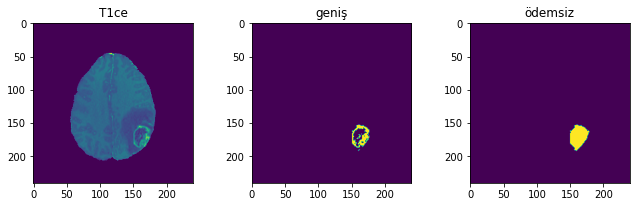

In [28]:
#Segmente edilmis goruntulerin genisleyen tumor ve genisleyen tumor+nekroz bolgeleri icin tumor goruntuleri

plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce[174,0,:,:])

plt.subplot(3,4,2)
plt.title('geniş')
plt.imshow(seg_geniş[174,0,:,:])

plt.subplot(3,4,3)
plt.title('ödemsiz')
plt.imshow(seg_ödemsiz[174,0,:,:])


In [29]:
#Threshold kullanarak yapilan koordinat bazli kirpma algoritmasi

def tümör_kırpma(mr,seg):
    
    mr = mr[0]
    liste = []
    tmp = seg[0,:,:]

    #threshold
    tmp[tmp>0.2] = 1
    tmp[tmp!= 1] = 0

    index_xy = np.where(tmp==1)
    
    if index_xy[0] != []:
        merkez_y = (max(index_xy[0]) + (min(index_xy[0])) ) / 2
        merkez_x = (max(index_xy[1]) + (min(index_xy[1])) ) / 2
        img_x =  np.zeros((64,64), np.float32)
        img_x[:,:] = mr[int(merkez_y - 64/2):int(merkez_y + 64/2),int(merkez_x - 64/2):int(merkez_x + 64/2) ]
        liste.append(img_x)
        
    return np.array(liste)

#Kirpilan goruntulerin diziye atilmasini saglayan fonksiyon

def tumortoarray(tumor,segmentasyon):
    
    liste_boş= []

    for i in range(len(segmentasyon)):
        img = tümör_kırpma(tumor[i],segmentasyon[i])
        if len(img.shape) > 2:
            liste_boş.append(img)
            #print(f'{i}')

    return np.array(liste_boş)



In [30]:
#Segmente edilmis genisleyen tumor ve nekroz+genisleyen tumor bolgelerinin goruntulerinin bir degiskene atanarak modele verilecek hale getirilmesi

ödemsiz = tumortoarray(seg_ödemsiz,seg_ödemsiz)
geniş = tumortoarray(seg_geniş,seg_ödemsiz)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


In [31]:
t1ce_kırp = tumortoarray(t1ce,seg_ödemsiz)#Kirpilmis T1ce goruntulerinin bir degiskene atanarak modele verilecek hale getirilmesi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


In [32]:
# Kirpilmis goruntunun boyutlari
t1ce_kırp.shape, ödemsiz.shape, geniş.shape

((747, 1, 64, 64), (747, 1, 64, 64), (747, 1, 64, 64))

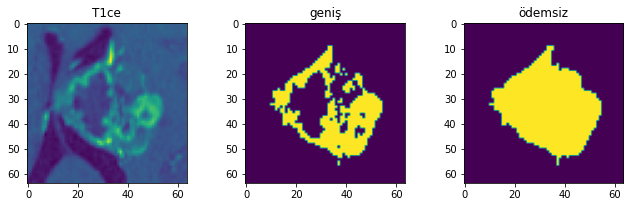

In [34]:
#Kirpilmis T1ce goruntulerinin;segmente edilmis genisleyen tumor ve genisleyen tumor+nekroz bolgeleri icin tumor tahminleri

plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce_kırp[500,0,:,:])

plt.subplot(3,4,2)
plt.title('geniş')
plt.imshow(geniş[500,0,:,:])

plt.subplot(3,4,3)
plt.title('ödemsiz')
plt.imshow(ödemsiz[500,0,:,:])

In [35]:
def unet_model_7():
    
    inputs = Input((1, 64, 64))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
     
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch5)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer = Adam(lr = 1e-4), loss = ['binary_crossentropy'], metrics = [accuracy])

    return model

In [36]:
model_ödemsiz = unet_model_7()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [37]:

history = model_ödemsiz.fit(t1ce_kırp, ödemsiz,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 30,
                       shuffle=True,
                       verbose=1)

Epoch 1/30
60/60 [==============================] - 10s 81ms/step - loss: 0.5570 - accuracy: 0.3685 - val_loss: 0.4399 - val_accuracy: 0.1143
Epoch 2/30
60/60 [==============================] - 3s 43ms/step - loss: 0.1914 - accuracy: 0.7651 - val_loss: 0.3863 - val_accuracy: 0.0089
Epoch 3/30
60/60 [==============================] - 3s 43ms/step - loss: 0.1303 - accuracy: 0.8403 - val_loss: 0.4167 - val_accuracy: 0.0102
Epoch 4/30
60/60 [==============================] - 3s 43ms/step - loss: 0.1156 - accuracy: 0.8519 - val_loss: 0.4401 - val_accuracy: 0.0278
Epoch 5/30
60/60 [==============================] - 3s 43ms/step - loss: 0.1137 - accuracy: 0.8415 - val_loss: 0.3832 - val_accuracy: 0.1975
Epoch 6/30
60/60 [==============================] - 2s 41ms/step - loss: 0.0866 - accuracy: 0.8864 - val_loss: 0.3168 - val_accuracy: 0.3408
Epoch 7/30
60/60 [==============================] - 3s 43ms/step - loss: 0.0765 - accuracy: 0.8930 - val_loss: 0.2623 - val_accuracy: 0.4384
Epoch 8/30
6

In [38]:
model_geniş = unet_model_7()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [39]:

history = model_geniş.fit(t1ce_kırp, geniş,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 30,
                       shuffle=True,
                       verbose=1)

Epoch 1/30
60/60 [==============================] - 7s 61ms/step - loss: 0.6475 - accuracy: 0.2341 - val_loss: 0.5546 - val_accuracy: 0.4464
Epoch 2/30
60/60 [==============================] - 2s 41ms/step - loss: 0.3353 - accuracy: 0.6174 - val_loss: 0.3405 - val_accuracy: 0.2409
Epoch 3/30
60/60 [==============================] - 3s 43ms/step - loss: 0.2710 - accuracy: 0.6908 - val_loss: 0.2810 - val_accuracy: 0.1686
Epoch 4/30
60/60 [==============================] - 3s 43ms/step - loss: 0.2270 - accuracy: 0.7387 - val_loss: 0.2644 - val_accuracy: 0.1890
Epoch 5/30
60/60 [==============================] - 2s 42ms/step - loss: 0.1960 - accuracy: 0.7716 - val_loss: 0.2619 - val_accuracy: 0.1723
Epoch 6/30
60/60 [==============================] - 3s 44ms/step - loss: 0.1632 - accuracy: 0.7899 - val_loss: 0.2317 - val_accuracy: 0.3190
Epoch 7/30
60/60 [==============================] - 2s 41ms/step - loss: 0.1501 - accuracy: 0.8027 - val_loss: 0.2216 - val_accuracy: 0.4049
Epoch 8/30
60

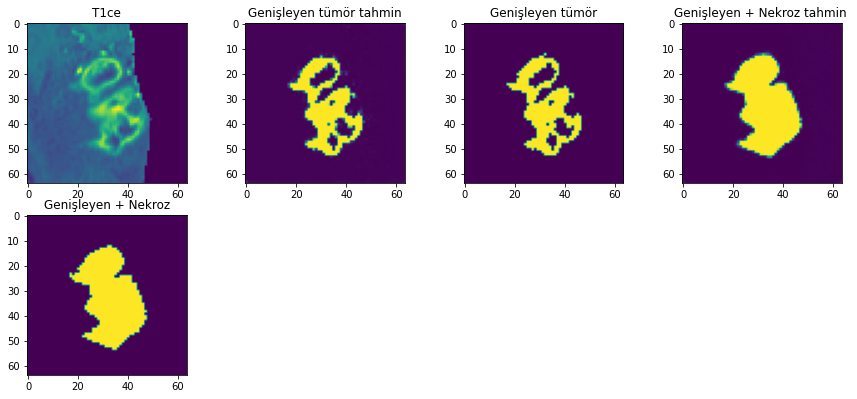

In [40]:
# Yogunluk kirpma algoritmasina gore kirpilmis goruntuler icin tahminler

x = 550

plt.figure(figsize=(15,10))


plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce_kırp[x,0,:,:])


pred_geniş = model_geniş.predict(t1ce_kırp[x:x+1,:,:,:])
plt.subplot(3,4,2)
plt.title('Genişleyen tümör tahmin')
plt.imshow(pred_geniş[0,0,:,:] )

plt.subplot(3,4,3)
plt.title('Genişleyen tümör')
plt.imshow(geniş[x,0,:,:])

pred_ödemsiz = model_ödemsiz.predict(t1ce_kırp[x:x+1,:,:,:])
plt.subplot(3,4,4)
plt.title('Genişleyen + Nekroz tahmin ')
plt.imshow(pred_ödemsiz[0,0,:,:] )


plt.subplot(3,4,5)
plt.title('Genişleyen + Nekroz')
plt.imshow(ödemsiz[x,0,:,:])



In [41]:
#Verilerin zip icerisinden cikarilmasini saglamaktadir.

from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Test2.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [42]:
#Yogunluk kirpma algoritmasi kullanarak yapilan koordinat ve yogunluk bazli kirpma algoritmasi

def kirpma(goruntu, tumor):

  print("------**>>>>>>{}".format(tumor.shape))

  liste = []

  ysol = 0
  ysag = 64

  xsol = 0
  xsag =64

  adim = 30

  tut = 0
  tutx = 0
  tutSize = 0

  while True:

    ysol = 0
    ysag = 64

    while True:
      if ysag >240:
        break
      t1CE = tumor.copy()
      kirpilan = t1CE[goruntu,0,ysol:ysag,xsol:xsag]
      kirpilan[kirpilan < 3.5] = 1
      print("ysol --> {}, ysag --> {}".format(ysol, ysag))
      print("xsol --> {}, xsag --> {}".format(xsol, xsag))
      print("Goruntu yogunlugu --> {}".format(kirpilan[kirpilan>3].size))
      print("***\n")
      ysol += adim
      ysag += adim

      if kirpilan[kirpilan>3].size > tutSize:
        tutSize = kirpilan[kirpilan>3].size
        tut = ysag
        tutx = xsag

    xsol += adim
    xsag += adim 
    if xsag >240:
        break

  tut -=30

  img_x =  np.zeros((64,64), np.float32)
  boyut2 = tumor[goruntu][0]
  img_x[:,:] = boyut2[tut-64:tut,tutx-64:tutx]
  liste.append(img_x)

  return np.array(liste)

#Dosyanin icinde train edilecek goruntulerin islenebilmesi icin goruntuleri bir diziye atan fonksiyon

def tumortoarray(tumor):

    liste_boş= []

    for i in range(len(tumor)):

        img = kirpma(i,tumor)
        print("------>{}.Adim".format(i))
        if len(img.shape) > 2:
            liste_boş.append(img)
            #print(f'{i}')

    return np.array(liste_boş)


#print(tumortoarray(t1ce).shape)

In [43]:
# Yogunluk kirpma algoritmasina gore segmente edilecek verilerin bulundugu klasor yolu

yol3 = '/content/Test2/MICCAI_BraTS2020_TrainingData/'
os.listdir(yol3)

['BraTS20_Training_246']

In [44]:
#Diziye atilan T1ce goruntulerinin bir degiskene atanarak modele verilecek hale getirilmesi


t1ceee = train_array(yol3,'**/*t1ce.nii')

In [45]:
# Kirpilmis goruntunun boyutu

t1ceee.shape

(70, 1, 240, 240)

In [ ]:
#Goruntu yogunluk oranina gore kirpilmistir

a = tumortoarray(t1ceee)

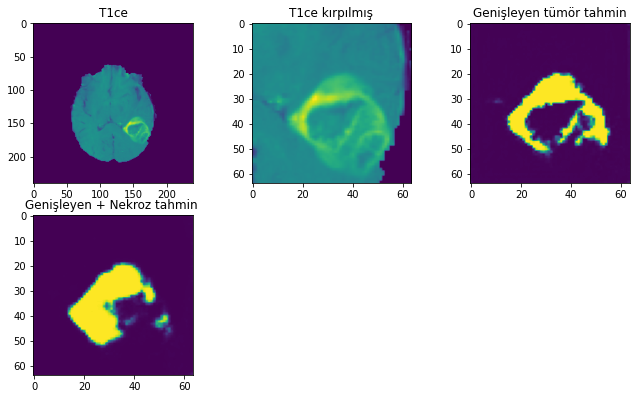

In [47]:
# Yogunluk kırpma algoritmasina gore kirpilmis goruntuler icin tahminler

x = 15

plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ceee[x,0,:,:])


plt.subplot(3,4,2)
plt.title('T1ce kırpılmış')
plt.imshow(a[x,0,:,:])


pred_geniş = model_geniş.predict(a[x:x+1,:,:,:])
plt.subplot(3,4,3)
plt.title('Genişleyen tümör tahmin')
plt.imshow(pred_geniş[0,0,:,:] )


pred_ödemsiz = model_ödemsiz.predict(a[x:x+1,:,:,:])
plt.subplot(3,4,5)
plt.title('Genişleyen + Nekroz tahmin ')
plt.imshow(pred_ödemsiz[0,0,:,:] )


